In [1]:
import pandas as pd
import numpy as np
from config import *

In [2]:
def get_market_year(row): #make a market year row in datas
    year = row['DATE'].year
    month = row['DATE'].month
    if month >= 9:
        market_year = f"{year}/{year + 1}"
    else:
        market_year = f"{year - 1}/{year}"
    return market_year

In [3]:
departements = { #set a dict of departement name as keys and dep code as value for missing dep values in datasets
    'Ain': 1,
    'Aisne': 2,
    'Allier': 3,
    'Alpes-de-Haute-Provence': 4,
    'Hautes-Alpes': 5,
    'Alpes-Maritimes': 6,
    'Ardèche': 7,
    'Ardennes': 8,
    'Ariège': 9,
    'Aube': 10,
    'Aude': 11,
    'Aveyron': 12,
    'Bouches-du-Rhône': 13,
    'Calvados': 14,
    'Cantal': 15,
    'Charente': 16,
    'Charente-Maritime': 17,
    'Cher': 18,
    'Corrèze': 19,
    'Corse': 20,
    "Côte-d'Or": 21,
    "Côtes-d'Armor": 22,
    'Creuse': 23,
    'Dordogne': 24,
    'Doubs': 25,
    'Drôme': 26,
    'Eure': 27,
    'Eure-et-Loir': 28,
    'Finistère': 29,
    'Gard': 30,
    'Haute-Garonne': 31,
    'Gers': 32,
    'Gironde': 33,
    'Hérault': 34,
    'Ille-et-Vilaine': 35,
    'Indre': 36,
    'Indre-et-Loire': 37,
    'Isère': 38,
    'Jura': 39,
    'Landes': 40,
    'Loir-et-Cher': 41,
    'Loire': 42,
    'Haute-Loire': 43,
    'Loire-Atlantique': 44,
    'Loiret': 45,
    'Lot': 46,
    'Lot-et-Garonne': 47,
    'Lozère': 48,
    'Maine-et-Loire': 49,
    'Manche': 50,
    'Marne': 51,
    'Haute-Marne': 52,
    'Mayenne': 53,
    'Meurthe-et-Moselle': 54,
    'Meuse': 55,
    'Morbihan': 56,
    'Moselle': 57,
    'Nièvre': 58,
    'Nord': 59,
    'Oise': 60,
    'Orne': 61,
    'Pas-de-Calais': 62,
    'Puy-de-Dôme': 63,
    'Pyrénées-Atlantiques': 64,
    'Hautes-Pyrénées': 65,
    'Pyrénées-Orientales': 66,
    'Bas-Rhin': 67,
    'Haut-Rhin': 68,
    'Rhône': 69,
    'Haute-Saône': 70,
    'Saône-et-Loire': 71,
    'Sarthe': 72,
    'Savoie': 73,
    'Haute-Savoie': 74,
    'Paris': 75,
    'Seine-Maritime': 76,
    'Seine-et-Marne': 77,
    'Yvelines': 78,
    'Deux-Sèvres': 79,
    'Somme': 80,
    'Tarn': 81,
    'Tarn-et-Garonne': 82,
    'Var': 83,
    'Vaucluse': 84,
    'Vendée': 85,
    'Vienne': 86,
    'Haute-Vienne': 87,
    'Vosges': 88,
    'Yonne': 89,
    'Territoire de Belfort': 90,
    'Essonne': 91,
    'Hauts-de-Seine': 92,
    'Seine-Saint-Denis': 93,
    'Val-de-Marne': 94,
    "Val-d'Oise": 95
}

In [4]:
hist_weather_raw = pd.read_csv(f"{WEATHER_DATA_URL}/raw_rr_tn_tx_tm-1950-2023.csv").drop(["Unnamed: 0"], axis=1) #read raw weather data
current_weather_raw = pd.read_csv(f"{WEATHER_DATA_URL}/raw_rr_tn_tx_tm-current.csv").drop(["Unnamed: 0"], axis=1)
raw_weather = pd.concat([hist_weather_raw, current_weather_raw])

raw_weather = raw_weather.groupby(["DATE","DEP"]).mean().reset_index()
raw_weather["DATE"] = pd.to_datetime(raw_weather["DATE"])
raw_weather = raw_weather[raw_weather["DATE"] < raw_weather["DATE"].iloc[-1]] #remove last date of data, missing values
raw_weather["MY"] = raw_weather.apply(get_market_year, axis=1)
raw_weather["MONTH-DAY"] = raw_weather["DATE"].dt.strftime("%m-%d")
#remove years where there is no full data for a market year
raw_weather = raw_weather[(raw_weather["MY"] != "1949/1950") & (raw_weather["MY"] != "2024/2025")] 
raw_weather = raw_weather[raw_weather["MONTH-DAY"] != "02-29"] #remove leap years

raw_weather = raw_weather.dropna() #can't train on nan values so the sooner the better

In [5]:
weather_pivot = raw_weather.pivot_table( # Pivot table for month datas as columns and not rows
    index=['MY', 'DEP'],
    columns="MONTH-DAY",
    values=['RR', 'TN', 'TX', 'TM']
)
weather_pivot.columns = [ # rename columns with month number
    f"{col[0]}{col[1]}" if isinstance(col, tuple) and col[1] != "" 
    else col for col in weather_pivot.columns
]
weather_pivot = weather_pivot.reset_index()
weather_pivot = weather_pivot.dropna()

In [6]:
weather_pivot

,MY,DEP,RR01-01,RR01-02,RR01-03,RR01-04,RR01-05,RR01-06,RR01-07,RR01-08,...,TX12-22,TX12-23,TX12-24,TX12-25,TX12-26,TX12-27,TX12-28,TX12-29,TX12-30,TX12-31
1,1950/1951,2,2.400000,1.563158,0.478947,8.526316,0.700000,0.852632,0.605263,6.926316,...,-2.400000,-0.800000,-0.500000,-0.200000,-1.700000,-1.200000,-0.800000,-6.500000,-5.000000,1.700000
2,1950/1951,3,6.125641,0.677500,0.057500,0.087500,0.010000,0.082500,0.222500,0.347500,...,7.100000,1.600000,-0.925000,-3.425000,-1.600000,-1.250000,-0.925000,-2.600000,-3.550000,3.675000
3,1950/1951,5,4.121053,13.650000,0.831579,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.725000,-0.700000,3.225000,-0.100000,0.325000,0.400000,1.125000,-0.150000,-1.125000,-3.475000
4,1950/1951,6,4.821622,31.932432,12.394595,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.616667,8.116667,9.716667,9.816667,8.300000,7.066667,6.666667,9.466667,7.216667,7.933333
5,1950/1951,10,3.810000,4.870000,0.260000,2.230000,0.020000,0.830000,0.600000,3.550000,...,-0.266667,1.266667,-1.800000,-0.733333,-0.933333,0.233333,-0.400000,-4.000000,-3.166667,3.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6268,2023/2024,91,7.683333,6.733333,7.650000,0.033333,0.200000,0.333333,0.100000,0.933333,...,11.400000,10.750000,11.583333,11.950000,10.583333,10.566667,10.650000,11.216667,11.350000,10.450000
6269,2023/2024,92,8.600000,6.700000,4.800000,0.200000,0.200000,0.800000,0.000000,1.000000,...,11.800000,12.700000,13.600000,12.900000,11.600000,12.000000,12.400000,12.100000,11.900000,11.800000
6270,2023/2024,93,8.200000,5.700000,4.400000,0.000000,0.000000,0.600000,0.000000,0.000000,...,11.800000,12.400000,12.900000,12.600000,11.400000,11.500000,11.600000,11.700000,11.800000,11.800000
6271,2023/2024,94,9.100000,9.650000,6.400000,0.000000,0.000000,0.400000,0.100000,0.450000,...,11.800000,11.700000,12.800000,12.600000,11.500000,11.500000,11.550000,11.800000,11.650000,11.900000


In [7]:
raw_vpd = pd.read_csv(f"{VPD_DATA_URL}/ERA5/1940-2025_vpd.csv").drop(["Unnamed: 0", "departement"], axis=1)
raw_vpd = raw_vpd.dropna()
raw_vpd = raw_vpd.rename(columns={"date":"DATE", "dep":"DEP"})
raw_vpd["DATE"] = pd.to_datetime(raw_vpd["DATE"])
raw_vpd["MY"] = raw_vpd.apply(get_market_year, axis=1)
#remove years where there is no full data for a market year
raw_vpd = raw_vpd[(raw_vpd["MY"] != "1939/1940") & (raw_vpd["MY"] != "2024/2025")] 
raw_vpd["MONTH-DAY"] = raw_vpd["DATE"].dt.strftime("%m-%d")
raw_vpd = raw_vpd[raw_vpd["MONTH-DAY"] != "02-29"] #remove leap years

In [8]:
vpd_pivot = raw_vpd.pivot_table( # Pivot table for month datas as columns and not rows
    index=['MY', 'DEP'],
    columns="MONTH-DAY",
    values=['vpd_max', 'vpd_mean', 'vpd_min']
)
vpd_pivot.columns = [ # rename columns with month number
    f"{col[0]}{col[1]}" if isinstance(col, tuple) and col[1] != "" 
    else col for col in vpd_pivot.columns
]
vpd_pivot = vpd_pivot.reset_index()

In [9]:
vpd_pivot

,MY,DEP,vpd_max01-01,vpd_max01-02,vpd_max01-03,vpd_max01-04,vpd_max01-05,vpd_max01-06,vpd_max01-07,vpd_max01-08,...,vpd_min12-22,vpd_min12-23,vpd_min12-24,vpd_min12-25,vpd_min12-26,vpd_min12-27,vpd_min12-28,vpd_min12-29,vpd_min12-30,vpd_min12-31
0,1940/1941,1,0.132354,0.093340,0.109083,0.089246,0.083568,0.074628,0.098343,0.094229,...,0.030227,0.053570,0.039393,0.025857,0.016992,0.019505,0.027384,0.030492,0.038333,0.055430
1,1940/1941,2,0.165009,0.214080,0.198853,0.163985,0.147468,0.134596,0.129717,0.153086,...,0.099755,0.076699,0.054817,0.058276,0.029522,0.022392,0.029557,0.023802,0.005602,0.002414
2,1940/1941,3,0.148820,0.142861,0.107388,0.113023,0.101335,0.099834,0.116278,0.077015,...,0.033520,0.095137,0.071986,0.056618,0.038118,0.019662,0.015799,0.061468,0.037086,0.047029
3,1940/1941,4,0.140340,0.080095,0.116702,0.146266,0.191767,0.065463,0.062133,0.186698,...,0.044506,0.043099,0.030873,0.023123,0.019892,0.022255,0.026260,0.046517,0.057726,0.016833
4,1940/1941,5,0.111647,0.057454,0.072901,0.095202,0.110487,0.059091,0.076325,0.143007,...,0.021719,0.032656,0.025410,0.014698,0.012184,0.016012,0.016404,0.037558,0.038403,0.012515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,2023/2024,89,0.283134,0.245179,0.259011,0.282445,0.294730,0.153310,0.100484,0.164398,...,0.084235,0.082826,0.110970,0.097442,0.112299,0.075556,0.116377,0.090418,0.063831,0.146829
7724,2023/2024,90,0.199950,0.211431,0.399459,0.244395,0.133245,0.110667,0.121237,0.109534,...,0.037877,0.075001,0.120394,0.129238,0.056776,0.028053,0.082429,0.063444,0.034981,0.021536
7725,2023/2024,91,0.302723,0.209739,0.334163,0.241236,0.336526,0.242142,0.143298,0.164703,...,0.127071,0.126732,0.165520,0.144169,0.083230,0.082129,0.090718,0.079024,0.047687,0.140487
7726,2023/2024,94,0.308881,0.215436,0.321815,0.261003,0.335451,0.217595,0.155188,0.163629,...,0.104290,0.150739,0.182253,0.152527,0.073675,0.080210,0.093177,0.077897,0.053399,0.162159


In [10]:
raw_ndvi = pd.read_csv(f"{NDVI_DATA_URL}/ndvi_processed.csv").drop(["Unnamed: 0", "departement"], axis=1)
raw_ndvi = raw_ndvi.dropna()
raw_ndvi = raw_ndvi.rename(columns={"date":"DATE", "dep":"DEP"})
raw_ndvi["DATE"] = pd.to_datetime(raw_ndvi["DATE"])
raw_ndvi["MY"] = raw_ndvi.apply(get_market_year, axis=1)
#remove years where there is no full data for a market year
raw_ndvi = raw_ndvi[(raw_ndvi["MY"] != "1980/1981") & (raw_ndvi["MY"] != "2024/2025")] 
#raw_ndvi = raw_ndvi[raw_ndvi["DATE"] >= "1985-09-01"]
raw_ndvi["MONTH-DAY"] = raw_ndvi["DATE"].dt.strftime("%m-%d")
raw_ndvi = raw_ndvi[raw_ndvi["MONTH-DAY"] != "02-29"] #remove leap years

In [11]:
ndvi_pivot = raw_ndvi.pivot_table( # Pivot table for month datas as columns and not rows
    index=['MY', 'DEP'],
    columns="MONTH-DAY",
    values=['ndvi_mean']
)
ndvi_pivot.columns = [ # rename columns with month number
    f"{col[0]}{col[1]}" if isinstance(col, tuple) and col[1] != "" 
    else col for col in ndvi_pivot.columns
]
ndvi_pivot = ndvi_pivot.reset_index()
ndvi_pivot = ndvi_pivot.ffill(axis=1) #we fill some of the missing values (NaN values cause of night, cloud...) with the previous day value, NaNs are here and there on the dataset so we can do this

In [12]:
ndvi_pivot

,MY,DEP,ndvi_mean01-01,ndvi_mean01-02,ndvi_mean01-03,ndvi_mean01-04,ndvi_mean01-05,ndvi_mean01-06,ndvi_mean01-07,ndvi_mean01-08,...,ndvi_mean12-22,ndvi_mean12-23,ndvi_mean12-24,ndvi_mean12-25,ndvi_mean12-26,ndvi_mean12-27,ndvi_mean12-28,ndvi_mean12-29,ndvi_mean12-30,ndvi_mean12-31
0,1981/1982,1,-0.00056,-0.032711,0.16273,-0.01887,0.00685,0.22456,0.02133,0.02133,...,0.0067,-0.02276,-0.002756,-0.00535,0.08697,-0.01122,-0.01383,0.085314,0.085314,0.0197
1,1981/1982,2,0.111329,0.011386,0.150171,-0.002614,0.0,0.225729,0.118893,0.118893,...,0.009107,-0.028221,-0.013964,0.000964,0.011569,-0.023729,0.278446,0.023807,0.023807,0.057607
2,1981/1982,3,0.14475,-0.020607,0.236,0.211233,-0.007847,0.209067,-0.035529,-0.035529,...,0.007167,0.008173,-0.037907,0.08962,0.25756,-0.010427,-0.02136,0.135707,0.135707,-0.017167
3,1981/1982,4,0.03092,0.11102,0.136664,0.158282,0.11462,0.11462,0.159173,0.159173,...,-0.00566,0.0,0.012636,0.111282,0.089127,-0.002636,0.003527,0.019327,0.019327,-0.0017
4,1981/1982,5,0.0102,0.023113,0.00283,0.00131,0.006,0.006,0.0586,0.0586,...,-0.014711,0.006382,0.021964,-0.00928,-0.021091,-0.001418,0.009136,0.052855,0.052855,0.013036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,2023/2024,90,0.2205,-0.0287,0.3903,0.0665,-0.0187,-0.0031,-0.0113,-0.0105,...,-0.0171,0.0442,-0.0047,0.6829,0.0294,0.2688,0.0154,0.0152,0.4527,-0.0191
3995,2023/2024,91,0.2006,-0.02225,0.0054,-0.0014,0.5155,0.31625,-0.0035,0.0355,...,0.00345,0.00725,0.24195,0.00775,0.0122,0.1244,0.00325,-0.0035,0.0219,0.4173
3996,2023/2024,92,0.1747,-0.0236,-0.0219,0.0238,0.0819,0.0305,-0.0166,0.0025,...,-0.0008,0.0153,0.1557,0.0039,-0.0117,0.0933,0.0112,0.0,-0.0092,0.3743
3997,2023/2024,94,0.2221,-0.0249,-0.0129,0.0026,0.3455,0.0045,-0.0222,-0.0099,...,-0.0183,0.0012,0.2727,-0.0138,-0.0213,0.1173,0.0,-0.0054,-0.0246,0.4065


1st dataset (1900 - 2018)

In [13]:
yields_raw = pd.read_csv(f"{YIELDS_DATA_URL}/2021-001_Schauberger-et-al_Data_FILTERED/wheat_total_data_1900-2018_FILTERED.txt", sep=';')

#aggregate Corse du sud and Haute Corse into one Corse department :
corseSud = yields_raw[yields_raw['department'] == "Corse-du-sud"].fillna(0)
corseHaute = yields_raw[yields_raw['department'] == "Haute-Corse"].fillna(0)
corseArea = corseSud["area"].reset_index(drop=True) + corseHaute["area"].reset_index(drop=True)
corseProd = corseSud["production"].reset_index(drop=True) + corseHaute["production"].reset_index(drop=True)
corseYield = (corseSud["production"].reset_index(drop=True) + corseHaute["production"].reset_index(drop=True)) / (corseSud["area"].reset_index(drop=True) + corseHaute["area"].reset_index(drop=True))
corseYears = pd.Series(range(1900, 2019))
corse = pd.DataFrame({"department": "Corse", "year": corseYears, "yield": corseYield, "area": corseArea, "production": corseProd})
yields_raw = pd.concat([yields_raw, corse])
yields_raw = yields_raw[(yields_raw['department'] != "Corse-du-sud") & (yields_raw['department'] != "Haute-Corse")]

yields_raw['DEP'] = yields_raw['department'].map(departements).replace('NA', np.nan) #map dep name to dep code
yields_raw = yields_raw.drop("department", axis=1)
yields_raw["MY"] = (yields_raw['year'] - 1).astype(str) + '/' + yields_raw['year'].astype(str) 
oldYields = yields_raw.copy()

2nd dataset (2000 - 2024)

In [14]:
yields_raw = pd.read_csv(f"{YIELDS_DATA_URL}/SCR-GRC-hist_dep_surface_prod_cult_cer-A25.csv", encoding='utf-8')
yields_raw["ESPECES"] = yields_raw["ESPECES"].str.strip() #remove left and white spaces
yields_raw = yields_raw[yields_raw["ESPECES"] == "Blé tendre"].reset_index(drop=True) #filter soft wheat

#Corse
corseSud = yields_raw[yields_raw["DEP"] == "2A"]
corseSud = pd.concat([pd.DataFrame({'ANNEE': list(range(2000, 2016))}), corseSud], ignore_index=True).fillna(0)
corseHaute = yields_raw[yields_raw['DEP'] == "2B"].fillna(0)
corseArea = corseSud["CULT_SURF"].reset_index(drop=True) + corseHaute["CULT_SURF"].reset_index(drop=True)
corseProd = corseSud["CULT_PROD"].reset_index(drop=True) + corseHaute["CULT_PROD"].reset_index(drop=True)
corseYield = (corseSud["CULT_PROD"].reset_index(drop=True) + corseHaute["CULT_PROD"].reset_index(drop=True)) / (corseSud["CULT_SURF"].reset_index(drop=True) + corseHaute["CULT_SURF"].reset_index(drop=True))
corseYears = pd.Series(range(2000, 2026))
corse = pd.DataFrame({"DEPARTEMENT": "Corse", "DEP": 20, "ANNEE": corseYears, "CULT_REND": corseYield, "CULT_SURF": corseArea, "CULT_PROD": corseProd})
yields_raw = pd.concat([yields_raw, corse])
yields_raw = yields_raw[(yields_raw['DEP'] != "2A") & (yields_raw['DEP'] != "2B")]

yields_raw["DEP"] = yields_raw["DEP"].astype(int)
yields = yields_raw[["ANNEE", "DEP", "CULT_SURF", "CULT_REND", "CULT_PROD"]] #keep only wanted data
yields["MY"] = (yields['ANNEE'] - 1).astype(str) + '/' + yields['ANNEE'].astype(str) 
yields = yields.rename(columns={"ANNEE": "year", "CULT_SURF": "area", "CULT_REND": "yield", "CULT_PROD": "production"})
yields['yield'] = yields['yield'] / 10 #convert to kg/ha
newYields = yields[yields["year"] <= 2024] #-> final yield data

C:\Users\alexl\AppData\Local\Temp\ipykernel_16200\1724735824.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yields["MY"] = (yields['ANNEE'] - 1).astype(str) + '/' + yields['ANNEE'].astype(str)


Concat both yields datasets

In [15]:
newYields = newYields[newYields['year'] >= 2019]
yields = pd.concat([oldYields, newYields])
yields = yields.dropna().reset_index(drop=True)
yields

,year,yield,area,production,DEP,MY
0,1900,1.44401,95230.0,137513.0,1,1899/1900
1,1901,1.02637,92300.0,94734.0,1,1900/1901
2,1902,0.99449,93150.0,92636.4,1,1901/1902
3,1903,1.20303,92714.0,111537.7,1,1902/1903
4,1904,0.98300,89094.0,87579.4,1,1903/1904
...,...,...,...,...,...,...
10835,2020,0.35000,72.0,252.0,20,2019/2020
10836,2021,0.65000,99.0,643.5,20,2020/2021
10837,2022,0.65000,83.0,539.5,20,2021/2022
10838,2023,0.40000,63.0,252.0,20,2022/2023


In [16]:
som_pom = pd.read_json(f"{SOM_DATA_URL}/pom.json") #read json
som_pom['DEP'] = som_pom['nom'].map(departements) #map dep name to dep codevpd['DEP'] = vpd['dep'].map(departements) #map dep name to dep code
som_pom = som_pom.drop("nom", axis=1) #remove unwanted dep name -> final som pom data

In [17]:
maom_pom = pd.read_json(f"{SOM_DATA_URL}/maom.json") #read json
maom_pom['DEP'] = maom_pom['nom'].map(departements) #map dep name to dep codevpd['DEP'] = vpd['dep'].map(departements) #map dep name to dep code
maom_pom = maom_pom.drop("nom", axis=1) #remove unwanted dep name -> final som maom data

In [18]:
awc = pd.read_json(f"{AWC_DATA_URL}/AWC.json") #read json
awc['DEP'] = awc['nom'].map(departements) #map dep name to dep codevpd['DEP'] = vpd['dep'].map(departements) #map dep name to dep code
awc = awc.drop("nom", axis=1) #remove unwanted dep name -> final AWC data

In [19]:
weather_vpd = pd.merge(weather_pivot, vpd_pivot, on=['DEP', 'MY'], how="inner")
weather_vpd_ndvi = pd.merge(weather_vpd, ndvi_pivot, on=['DEP', 'MY'], how="inner")
weather_vpd_ndvi_yields = pd.merge(weather_vpd_ndvi, yields, on=['DEP', 'MY'], how="inner")

som_maom = pd.merge(som_pom, maom_pom, on="DEP", how='inner')
som_maom_awc = pd.merge(som_maom, awc, on="DEP", how='inner')

result = pd.merge(weather_vpd_ndvi_yields, som_maom_awc, on="DEP", how="inner")

In [22]:
cols_to_front = ['year', 'yield', 'area', 'production']
remaining_cols = [col for col in result.columns if col not in cols_to_front]
new_order = cols_to_front + remaining_cols
result = result[new_order]

In [23]:
result

,year,yield,area,production,MY,DEP,RR01-01,RR01-02,RR01-03,RR01-04,...,ndvi_mean12-25,ndvi_mean12-26,ndvi_mean12-27,ndvi_mean12-28,ndvi_mean12-29,ndvi_mean12-30,ndvi_mean12-31,pom,maom,awc
0,1982,5.00000,38050.0,190250.0,1981/1982,1,9.705000,0.000000,2.260000,3.822500,...,-0.00535,0.08697,-0.01122,-0.01383,0.085314,0.085314,0.0197,16.789692,26.925089,0.107088
1,1982,6.44000,175000.0,1127000.0,1981/1982,2,1.282258,4.706452,1.335484,4.774194,...,0.000964,0.011569,-0.023729,0.278446,0.023807,0.023807,0.057607,5.252623,18.222063,0.095255
2,1982,4.51238,45564.0,205602.0,1981/1982,3,1.560870,0.156522,0.415217,1.678261,...,0.08962,0.25756,-0.010427,-0.02136,0.135707,0.135707,-0.017167,6.453841,21.526911,0.089040
3,1982,2.62370,13517.0,35464.5,1981/1982,4,1.262857,0.000000,0.000000,0.042857,...,0.111282,0.089127,-0.002636,0.003527,0.019327,0.019327,-0.0017,16.788250,28.354742,0.118781
4,1982,3.80000,5500.0,20900.0,1981/1982,5,4.735897,0.000000,0.000000,0.000000,...,-0.00928,-0.021091,-0.001418,0.009136,0.052855,0.052855,0.013036,29.324879,31.984188,0.119110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,2024,5.30000,106900.0,566570.0,2023/2024,89,6.865000,12.315000,6.090000,0.290000,...,-0.00676,0.041033,0.2898,-0.01736,0.11888,0.203113,0.261347,5.579002,19.594700,0.102762
3658,2024,5.30000,2600.0,13780.0,2023/2024,90,3.800000,27.371429,13.185714,2.614286,...,0.6829,0.0294,0.2688,0.0154,0.0152,0.4527,-0.0191,16.129911,28.980818,0.105598
3659,2024,6.20000,24714.0,153226.8,2023/2024,91,7.683333,6.733333,7.650000,0.033333,...,0.00775,0.0122,0.1244,0.00325,-0.0035,0.0219,0.4173,4.623960,16.732876,0.088218
3660,2024,6.20000,227.0,1407.4,2023/2024,94,9.100000,9.650000,6.400000,0.000000,...,-0.0138,-0.0213,0.1173,0.0,-0.0054,-0.0246,0.4065,5.895328,20.545574,0.084148


In [24]:
result.to_csv("daily_wheat_model_dataset_1980-2024.csv")

In [53]:
test_ndvi = raw_ndvi[(raw_ndvi["DEP"] == 79) & (raw_ndvi["MY"] == "2021/2022")]

<Axes: xlabel='DATE'>

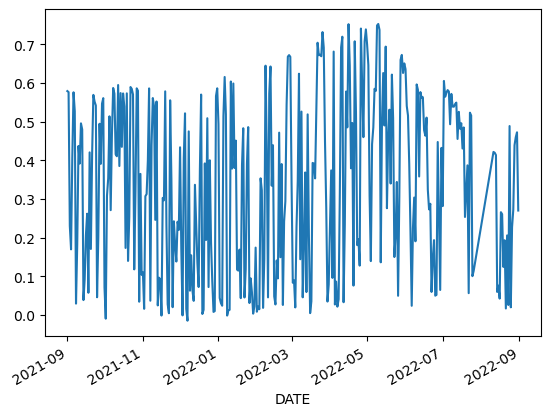

In [54]:
test_ndvi = test_ndvi.set_index("DATE")
test_ndvi["ndvi_mean"].plot()

In [55]:
test_ndvi

,DEP,ndvi_mean,MY,MONTH-DAY
DATE,,,,
2021-09-01,79,0.579273,2021/2022,09-01
2021-09-02,79,0.576727,2021/2022,09-02
2021-09-03,79,0.230164,2021/2022,09-03
2021-09-04,79,0.169600,2021/2022,09-04
2021-09-05,79,0.406245,2021/2022,09-05
...,...,...,...,...
2022-08-27,79,0.272409,2021/2022,08-27
2022-08-28,79,0.439173,2021/2022,08-28
2022-08-29,79,0.459982,2021/2022,08-29


In [51]:
evi = pd.read_json(f"{EVI_DATA_URL}/monthlyDepMean/79-Deux-Sèvres.json") #read json
evi["date"] = pd.to_datetime(evi["date"])
evi = evi.rename(columns={"date":"DATE"})
evi["MY"] = evi.apply(get_market_year, axis=1)
evi = evi[evi["MY"] == "2021/2022"]
evi = evi.sort_values(by="DATE")
evi = evi.set_index("DATE")

<Axes: xlabel='DATE'>

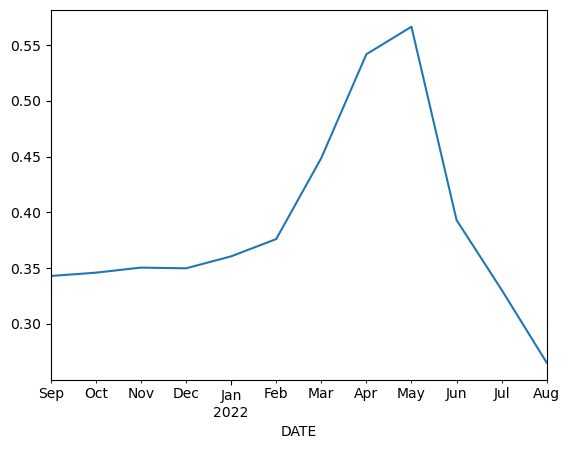

In [52]:
evi["mean_data"].plot()

In [56]:
lol = pd.read_csv(f"{NDVI_DATA_URL}/no_cloud/2022.csv")

In [60]:
lol = lol[lol["dep"] == 79]
lol = lol.set_index("date")

<Axes: xlabel='date'>

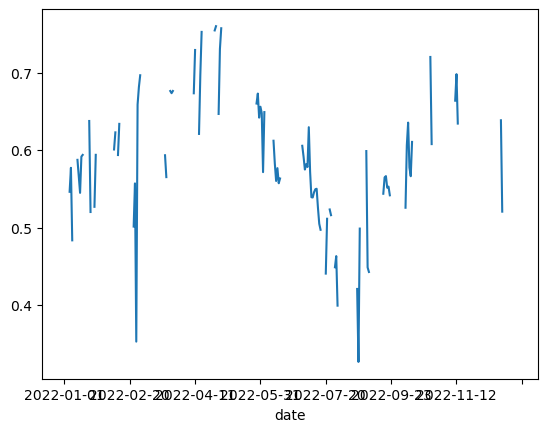

In [ ]:
lol["ndvi_mean"].plot()

<Axes: xlabel='date'>

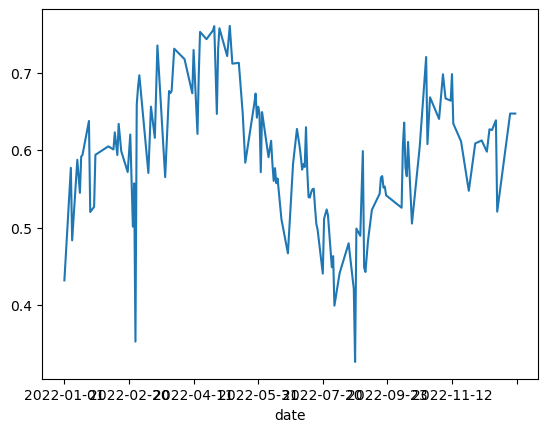

In [63]:
lol["ndvi_mean"].interpolate().plot()